In [6]:
import pandas as pd
import math
import statistics
import numpy as np
import scipy.stats

data = pd.read_csv("data\Steel_industry_data.csv")
#data



In [7]:
mean = sum(data['Usage_kWh']) / len(data['Usage_kWh'])
mean

27.386892408677415

Median

In [8]:
median = np.median(data['Usage_kWh'])
median

4.57

In [10]:
mode = statistics.mode(data['Usage_kWh'])
mode

3.06

In [11]:
var = statistics.variance(data['Usage_kWh'])
var

1118.5265340538936

In [12]:
std = statistics.stdev(data['Usage_kWh'])
std

33.44437970801512

In [13]:
percentiles = np.percentile(data['Usage_kWh'], [0, 25, 50, 75, 100])
percentiles

array([  0.    ,   3.2   ,   4.57  ,  51.2375, 157.18  ])

In [14]:
desc_stat = scipy.stats.describe(data['Usage_kWh'], ddof = 1, bias = False)
desc_stat

DescribeResult(nobs=35040, minmax=(0.0, 157.18), mean=27.386892408675795, variance=1118.526534053894, skewness=1.1973938227692211, kurtosis=0.3913856014239281)

In [15]:
data_series = pd.Series(data['Usage_kWh'])
desc_stat = data_series.describe()
desc_stat

count    35040.000000
mean        27.386892
std         33.444380
min          0.000000
25%          3.200000
50%          4.570000
75%         51.237500
max        157.180000
Name: Usage_kWh, dtype: float64

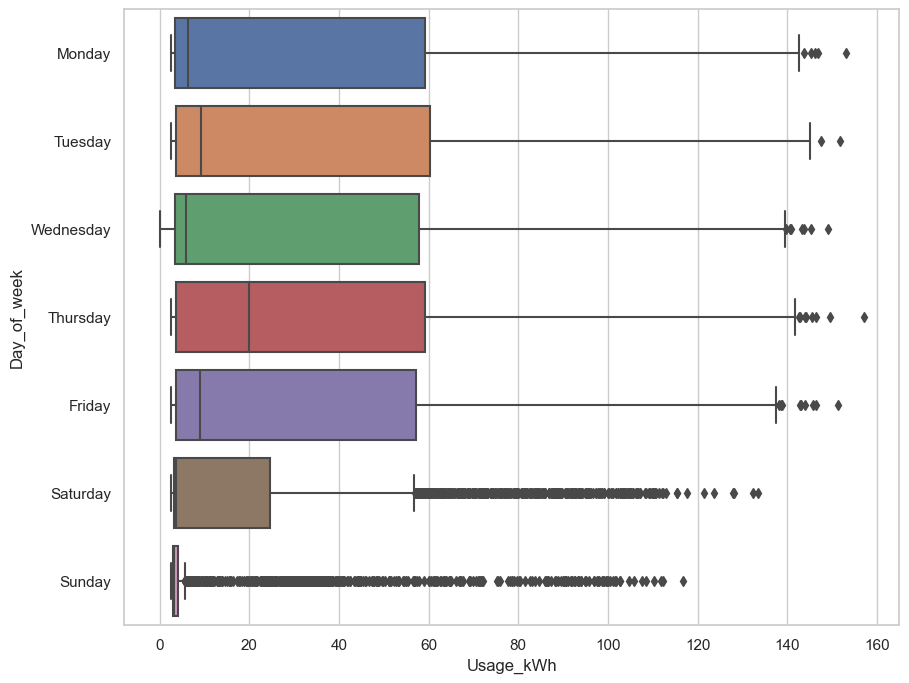

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='Usage_kWh', data=data, y='Day_of_week', orient="h")

C:\Users\Tea\AppData\Local\Temp\ipykernel_14356\1477773921.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


<AxesSubplot: >

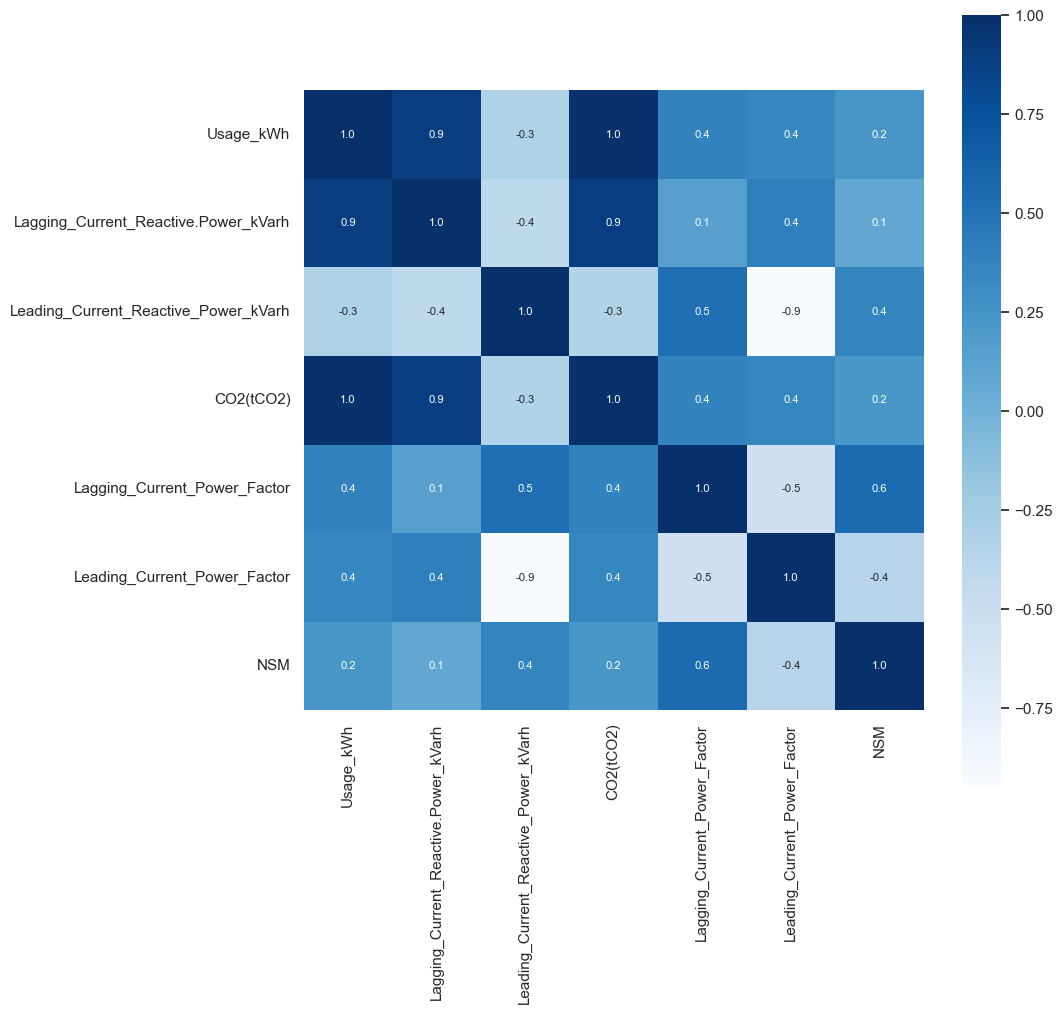

In [22]:
correlation = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')


In [23]:
data.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

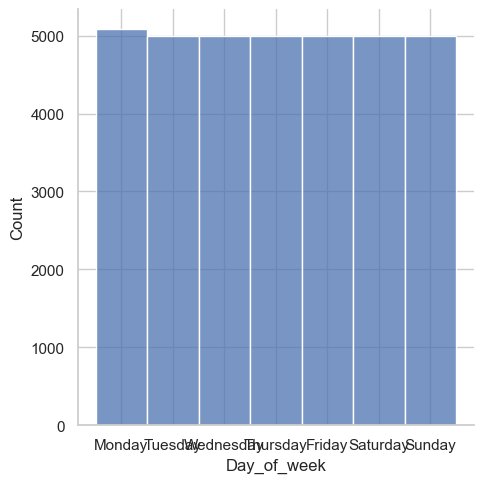

In [28]:
sns.displot(data['Day_of_week'])